In [513]:
using Distributions
using PyPlot
using HypothesisTests
using LinearAlgebra
using Interpolations

#= 前提
　　・データ：①二群の試行の成功数、失敗数、②試行にかかる時間
　　・サンプリング設定：各群のサンプルサイズを同一に固定し、データはバイアスなしでランダムにサンプリングするものとする
　　・統計モデル：①二項分布の直積、②指数分布
　　・知りたいこと：二群の真の平均に差はあるか
　　・帰無仮説：二群の真の平均に差はない
　　・対立仮説：二群の真の平均に差はある
　　・検定方法：①独立性のカイ二乗検定、Welch's t-test; ②Welch's t-test
　　・有意水準5％、検出力80％
　　・上記設定の下で必要な最小サンプルサイズを求める
=#

In [113]:
function binomial_sampling(sample_size, success_prob1, success_prob2, sampling_times)
    sample1 = rand(Binomial(sample_size, success_prob1), sampling_times)
    sample2 = rand(Binomial(sample_size, success_prob2), sampling_times)
    cont_tables = Array{Float64}(undef, 4, sampling_times) ## cont_tables(a, b): a番目のセルのb番目のサンプリングにおける値
    for i in 1:sampling_times
        cont_tables[:, i] = [sample1[i], sample_size-sample1[i], sample2[i], sample_size-sample2[i]]
    end
    return cont_tables
end

function expected(sample_size, success_prob1, success_prob2, sampling_times)
    cont_tables = binomial_sampling(sample_size, success_prob1, success_prob2, sampling_times)
    expected_mu1 = (cont_tables[1, :] .+ cont_tables[2, :]).*(cont_tables[1, :] .+ cont_tables[3, :]) ./ (2*sample_size)
    expected_mu2 = (cont_tables[1, :] .+ cont_tables[2, :]).*(cont_tables[2, :] .+ cont_tables[4, :]) ./ (2*sample_size)
    expected_mu3 = (cont_tables[3, :] .+ cont_tables[4, :]).*(cont_tables[1, :] .+ cont_tables[3, :]) ./ (2*sample_size)
    expected_mu4 = (cont_tables[3, :] .+ cont_tables[4, :]).*(cont_tables[2, :] .+ cont_tables[4, :]) ./ (2*sample_size)
    mu = Array{Float64}(undef, 4, sampling_times)
    mu[1, :] = expected_mu1
    mu[2, :] = expected_mu2
    mu[3, :] = expected_mu3
    mu[4, :] = expected_mu4
    return cont_tables, mu
end

function pval_chisq(sample_size, success_prob1, success_prob2, sampling_times)
    cont_tables, mu = expected(sample_size, success_prob1, success_prob2, sampling_times)
    chisq = Array{Float64}(undef, sampling_times)
    pval = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        chisq[i] = sum((cont_tables[:, i] .- mu[:, i]).^2 ./mu[:, i])
        pval[i] = ccdf(Chisq(1), chisq[i])
    end
    return cont_tables, mu, chisq, pval
end

function estimate_power(sample_size, success_prob1, success_prob2, sampling_times, alpha)
    cont_tables, mu, chisq, pval = pval_chisq(sample_size, success_prob1, success_prob2, sampling_times)
    test_results = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        if pval[i] < alpha
            test_results[i] = 1
        else
            test_results[i] = 0
        end
    end
    power = sum(test_results) / sampling_times
    return power
end

function estimate_minimum_sample_size(success_prob1, success_prob2, sampling_times, alpha, beta, delta_sample_size)
    power_list = Array{Float64}(undef, 0)
    i = 1
    while estimate_power(delta_sample_size*i, success_prob1, success_prob2, sampling_times, alpha) < 0.95
        push!(power_list, estimate_power(delta_sample_size*i, success_prob1, success_prob2, sampling_times, alpha))
        i += 1
    end
    sample_size_list = Array{Float64}(1:i-1) .* delta_sample_size
    spl_power_list = [power_list[power_list .< 0.8][end], power_list[power_list .> 0.8][1]]
    spl_sample_size_list = [sample_size_list[power_list .< 0.8][end], sample_size_list[power_list .> 0.8][1]]
    itp = LinearInterpolation(spl_power_list, spl_sample_size_list)
    minimum_sample_size = itp(beta)
    return minimum_sample_size
end

function plot_minimum_sample_size(sampling_times, alpha, beta, delta_sample_size, delta_prob)
    prob_list = Array{Float64}(delta_prob*2:delta_prob:1-delta_prob)
    minimum_sample_size_list = Array{Float64}(undef, size(prob_list)[1])
    for i in 1:size(prob_list)[1]
        minimum_sample_size_list[i] = estimate_minimum_sample_size(prob_list[i], prob_list[i]-delta_prob, sampling_times, alpha, beta, delta_sample_size)
    end
    plot(prob_list, minimum_sample_size_list)
    return minimum_sample_size_list
end

plot_minimum_sample_size (generic function with 3 methods)

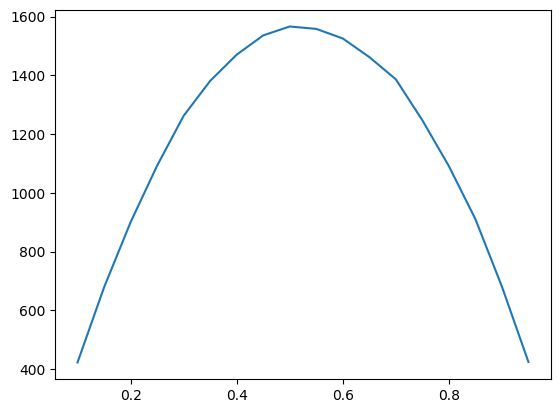

18-element Array{Float64,1}:
  422.4056603773585
  677.967032967033
  899.8295454545455
 1092.2950819672133
 1262.1176470588236
 1381.0843373493979
 1470.357142857143
 1536.0759493670887
 1566.428571428571
 1558.2524271844661
 1525.6701030927836
 1462.2972972972977
 1386.641221374046
 1247.2340425531916
 1091.0810810810813
  910.7368421052633
  680.9615384615386
  424.1573033707865

In [114]:
# 5％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size(10000, 0.05, 0.8, 30, 0.05)

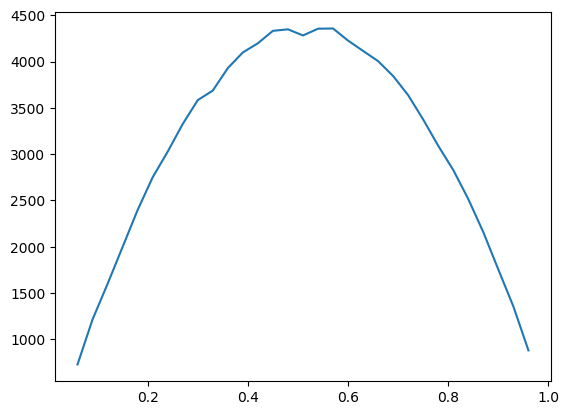

31-element Array{Float64,1}:
  729.2246520874753
 1215.1515151515152
 1599.6932515337423
 1998.2332155477034
 2397.142857142858
 2750.4273504273506
 3027.173913043479
 3325.806451612904
 3583.4586466165415
 3686.524822695036
 3929.1338582677163
 4098.245614035088
 4197.457627118644
    ⋮
 4114.583333333334
 4004.310344827587
 3843.333333333334
 3636.6336633663377
 3373.5849056603774
 3090.123456790124
 2828.75
 2514.814814814815
 2157.051282051282
 1753.5000000000002
 1355.2287581699347
  881.2392426850259

In [115]:
# 3％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size(10000, 0.05, 0.8, 100, 0.03)

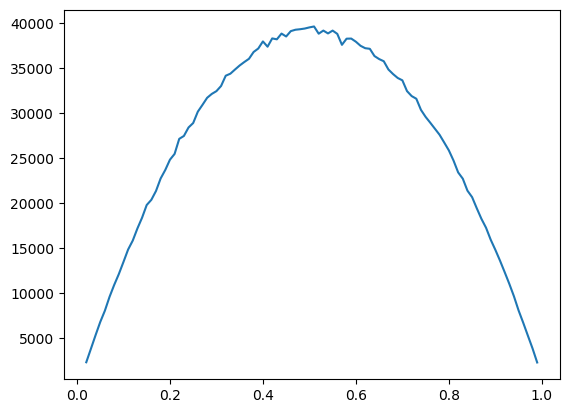

98-element Array{Float64,1}:
  2309.625668449198
  3806.8833652007647
  5314.814814814816
  6772.425249169437
  8030.232558139536
  9562.949640287772
 10887.755102040817
 12094.155844155845
 13441.988950276243
 14822.314049586777
 15817.258883248733
 17159.09090909091
 18351.06382978724
     ⋮
 17239.436619718315
 15915.697674418607
 14791.353383458647
 13593.75
 12320.652173913044
 11021.666666666668
  9633.72093023256
  8060.185185185186
  6692.45283018868
  5261.904761904763
  3849.2822966507183
  2286.019210245465

In [118]:
# 1％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size(10000, 0.05, 0.8, 500, 0.01)

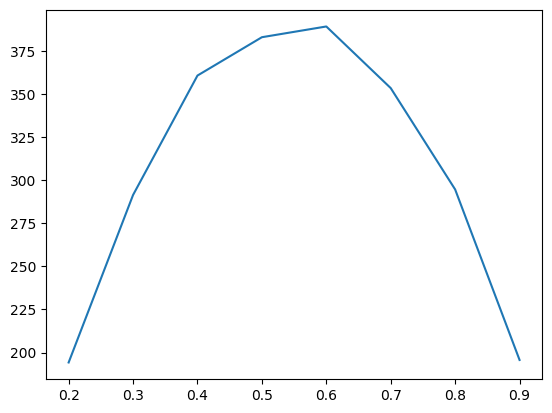

8-element Array{Float64,1}:
 194.21428571428572
 291.53846153846166
 360.945945945946
 383.22033898305074
 389.4594594594595
 353.6507936507937
 294.7647058823529
 195.67796610169495

In [119]:
# 10％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size(10000, 0.05, 0.8, 10, 0.1)

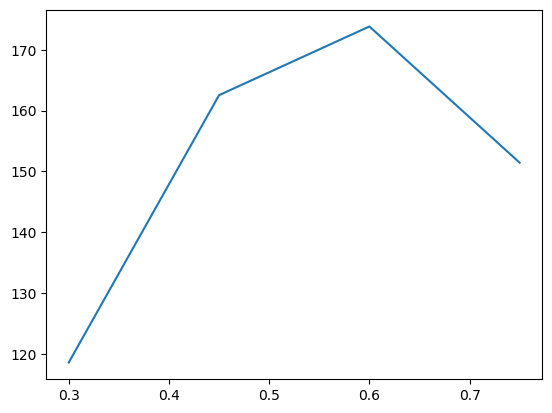

4-element Array{Float64,1}:
 118.62932226832643
 162.53557046979864
 173.81837606837598
 151.44036697247708

In [248]:
# 15％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size(100000, 0.05, 0.8, 1, 0.15)

In [324]:
# Welchのt検定の場合

function pval_welch(sample_size, success_prob1, success_prob2, sampling_times)
    cont_tables = binomial_sampling(sample_size, success_prob1, success_prob2, sampling_times)
    var1 = (cont_tables[1, :] .* (cont_tables[1, :]./sample_size .- 1).^2 .+ cont_tables[2, :] .* (cont_tables[1, :]./sample_size).^2) ./ (sample_size .- 1)
    var2 = (cont_tables[3, :] .* (cont_tables[3, :]./sample_size .- 1).^2 .+ cont_tables[4, :] .* (cont_tables[3, :]./sample_size).^2) ./ (sample_size .- 1)
    t = (cont_tables[1, :]./sample_size .- cont_tables[3, :]./sample_size) ./ ((var1 .+ var2)./sample_size).^0.5
    deg_of_freedom = ((var1 .+ var2)./sample_size).^2 ./ ((var1./sample_size).^2 ./ (sample_size-1) .+ (var2./sample_size).^2 ./(sample_size-1))
    pval = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        pval[i] = ccdf(TDist(deg_of_freedom[i]), t[i])
    end
    return pval
end

function estimate_power_welch(sample_size, success_prob1, success_prob2, sampling_times, alpha)
    pval = pval_welch(sample_size, success_prob1, success_prob2, sampling_times)
    test_results = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        if pval[i] < alpha
            test_results[i] = 1
        else
            test_results[i] = 0
        end
    end
    power = sum(test_results) / sampling_times
    return power
end

function estimate_minimum_sample_size_welch(success_prob1, success_prob2, sampling_times, alpha, beta, delta_sample_size)
    power_list = Array{Float64}(undef, 0)
    i = 1
    while estimate_power_welch(delta_sample_size*i, success_prob1, success_prob2, sampling_times, alpha) < 0.95
        push!(power_list, estimate_power_welch(delta_sample_size*i, success_prob1, success_prob2, sampling_times, alpha))
        i += 1
    end
    sample_size_list = Array{Float64}(1:i-1) .* delta_sample_size
    spl_power_list = [power_list[power_list .< 0.8][end], power_list[power_list .> 0.8][1]]
    spl_sample_size_list = [sample_size_list[power_list .< 0.8][end], sample_size_list[power_list .> 0.8][1]]
    itp = LinearInterpolation(spl_power_list, spl_sample_size_list)
    minimum_sample_size = itp(beta)
    return minimum_sample_size
end

function plot_minimum_sample_size_welch(sampling_times, alpha, beta, delta_sample_size, delta_prob)
    prob_list = Array{Float64}(delta_prob*2:delta_prob:1-delta_prob)
    minimum_sample_size_list = Array{Float64}(undef, size(prob_list)[1])
    for i in 1:size(prob_list)[1]
        minimum_sample_size_list[i] = estimate_minimum_sample_size_welch(prob_list[i], prob_list[i]-delta_prob, sampling_times, alpha, beta, delta_sample_size)
    end
    plot(prob_list, minimum_sample_size_list)
    return minimum_sample_size_list
end

plot_minimum_sample_size_welch (generic function with 1 method)

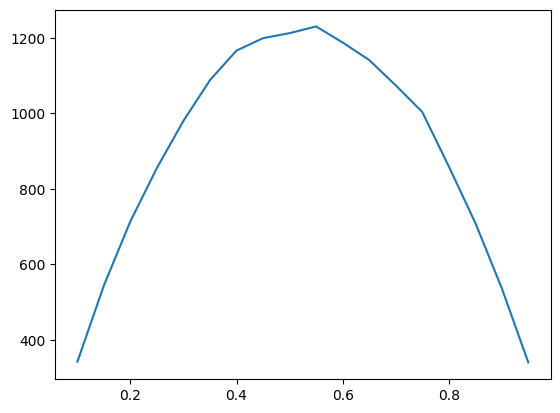

18-element Array{Float64,1}:
  342.60131950989637
  544.6107784431139
  714.5552560646902
  855.7114228456915
  980.3382663847781
 1088.0701754385966
 1166.1478599221791
 1198.9100817438693
 1212.3028391167193
 1229.9035369774924
 1187.5510204081634
 1141.1575562700966
 1074.1514360313317
 1003.7558685446011
  859.9290780141844
  710.3960396039606
  537.0826010544816
  340.5405405405406

In [244]:
# 5％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size_welch(10000, 0.05, 0.8, 100, 0.05)

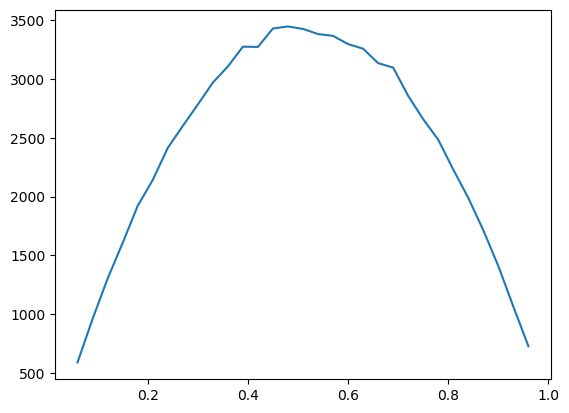

31-element Array{Float64,1}:
  587.764894042383
  957.8503688092732
 1300.7751937984494
 1604.2207792207796
 1919.8943661971834
 2139.9497487437193
 2413.186813186813
 2600.0
 2782.6530612244896
 2969.1648822269813
 3106.764705882353
 3275.645756457565
 3273.5083532219573
    ⋮
 3258.5209003215436
 3135.5932203389834
 3097.692307692308
 2857.063711911357
 2658.1545064377683
 2483.8137472283815
 2229.608938547486
 1988.8446215139447
 1713.004484304933
 1407.9245283018868
 1061.7647058823532
  725.625

In [245]:
# 3％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size_welch(10000, 0.05, 0.8, 300, 0.03)

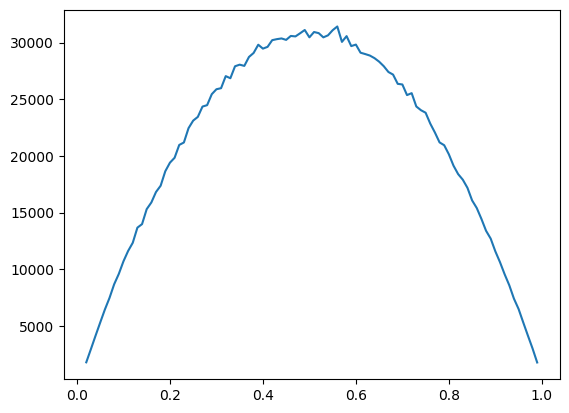

98-element Array{Float64,1}:
  1799.0797546012268
  2965.116279069768
  4150.118203309694
  5310.112359550562
  6451.776649746194
  7480.861244019141
  8683.54430379747
  9597.4025974026
 10707.729468599035
 11617.80104712042
 12340.361445783134
 13675.96566523605
 13987.455197132618
     ⋮
 13402.17391304348
 12708.029197080294
 11586.3309352518
 10631.14754098361
  9564.885496183206
  8594.036697247706
  7413.851351351352
  6501.824817518248
  5320.312500000001
  4160.167130919221
  3026.64298401421
  1785.0049652432972

In [247]:
# 1％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size_welch(10000, 0.05, 0.8, 500, 0.01)

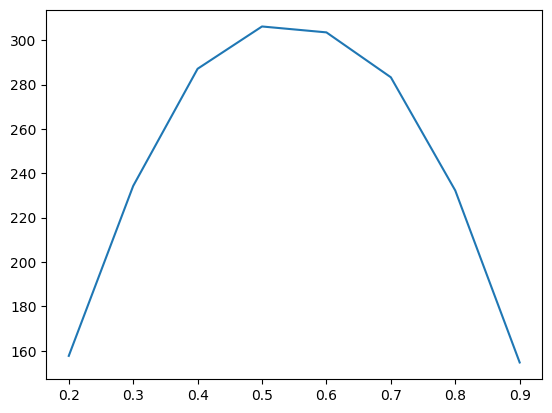

8-element Array{Float64,1}:
 157.67223382045933
 234.30521091811414
 287.1452420701169
 306.22529644268786
 303.5639412997904
 283.3057851239669
 232.25806451612905
 154.6986721144025

In [253]:
# 10％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size_welch(10000, 0.05, 0.8, 50, 0.1)

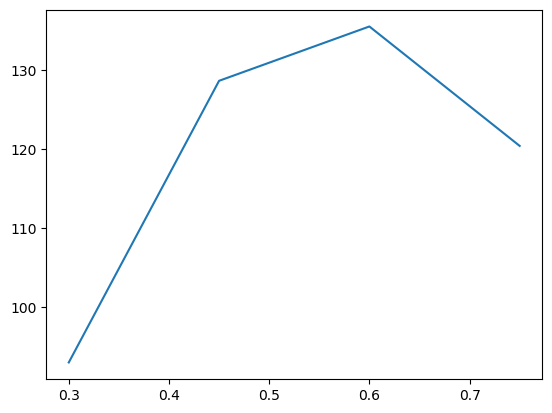

4-element Array{Float64,1}:
  93.028692879915
 128.66495507060336
 135.538752362949
 120.42857142857143

In [427]:
# 15％差を検出するために必要なサンプルサイズを推定
plot_minimum_sample_size_welch(10000, 0.05, 0.8, 30, 0.15)

In [503]:
# 認証時間の有意差検定を行う場合
function exp_sampling(sample_size, true_mean_time1, true_mean_time2, sampling_times)
    samples = Array{Float64}(undef, 2, sample_size, sampling_times)
    for i in 1:sampling_times
        sample1 = rand(Exponential(true_mean_time1), sample_size)
        sample2 = rand(Exponential(true_mean_time2), sample_size)
        samples[1, :, i] = sample1
        samples[2, :, i] = sample2
    end
    return samples
end

function exp_pval_welch(sample_size, true_mean_time1, true_mean_time2, sampling_times)
    samples = exp_sampling(sample_size, true_mean_time1, true_mean_time2, sampling_times)
    mean1 = Array{Float64}(undef, sampling_times)
    mean2 = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        mean1[i] = mean(samples[1, :, i])
        mean2[i] = mean(samples[2, :, i])
    end
    var1 = Array{Float64}(undef, sampling_times)
    var2 = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        var1[i] = norm(mean1[i] .- samples[1, :, i])^2 / (sample_size-1)
        var2[i] = norm(mean2[i] .- samples[2, :, i])^2 / (sample_size-1)
    end
    t = (mean1 .- mean2) ./ ((var1 .+ var2)./sample_size).^0.5
    deg_of_freedom = ((var1 .+ var2)./sample_size).^2 ./ ((var1./sample_size).^2 ./ (sample_size-1) .+ (var2./sample_size).^2 ./(sample_size-1))
    pval = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        pval[i] = ccdf(TDist(deg_of_freedom[i]), t[i])
    end
    return pval
end

function exp_estimate_power_welch(sample_size, true_mean_time1, true_mean_time2, sampling_times, alpha)
    pval = exp_pval_welch(sample_size, true_mean_time1, true_mean_time2, sampling_times)
    test_results = Array{Float64}(undef, sampling_times)
    for i in 1:sampling_times
        if pval[i] < alpha
            test_results[i] = 1
        else
            test_results[i] = 0
        end
    end
    power = sum(test_results) / sampling_times
    return power
end

function exp_estimate_minimum_sample_size_welch(true_mean_time1, true_mean_time2, sampling_times, alpha, beta, delta_sample_size)
    power_list = Array{Float64}(undef, 0)
    i = 1
    while exp_estimate_power_welch(delta_sample_size*i, true_mean_time1, true_mean_time2, sampling_times, alpha) < 0.95
        push!(power_list, exp_estimate_power_welch(delta_sample_size*i, true_mean_time1, true_mean_time2, sampling_times, alpha))
        i += 1
    end
    sample_size_list = Array{Float64}(1:i-1) .* delta_sample_size
    spl_power_list = [power_list[power_list .< 0.8][end], power_list[power_list .> 0.8][1]]
    spl_sample_size_list = [sample_size_list[power_list .< 0.8][end], sample_size_list[power_list .> 0.8][1]]
    itp = LinearInterpolation(spl_power_list, spl_sample_size_list)
    minimum_sample_size = itp(beta)
    return minimum_sample_size
end

function exp_plot_minimum_sample_size_welch(sampling_times, alpha, beta, delta_sample_size, delta_true_mean_time)
    true_mean_time_list = Array{Float64}(delta_true_mean_time*2:delta_true_mean_time:10)
    minimum_sample_size_list = Array{Float64}(undef, size(true_mean_time_list)[1])
    for i in 1:size(true_mean_time_list)[1]
        minimum_sample_size_list[i] = exp_estimate_minimum_sample_size_welch(true_mean_time_list[i], true_mean_time_list[i]-delta_true_mean_time, sampling_times, alpha, beta, delta_sample_size)
    end
    plot(true_mean_time_list, minimum_sample_size_list)
    return minimum_sample_size_list
end

exp_plot_minimum_sample_size_welch (generic function with 1 method)

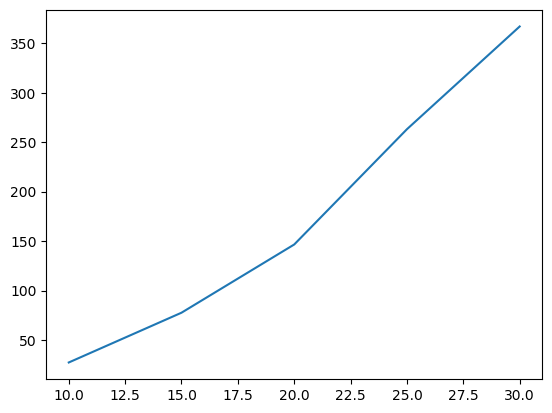

5-element Array{Float64,1}:
  27.34104046242775
  77.64705882352942
 146.6037735849057
 263.125
 366.95652173913044

In [496]:
# 5秒差を検出するために必要なサンプルサイズを推定
exp_plot_minimum_sample_size_welch(1000, 0.05, 0.8, 10, 5)

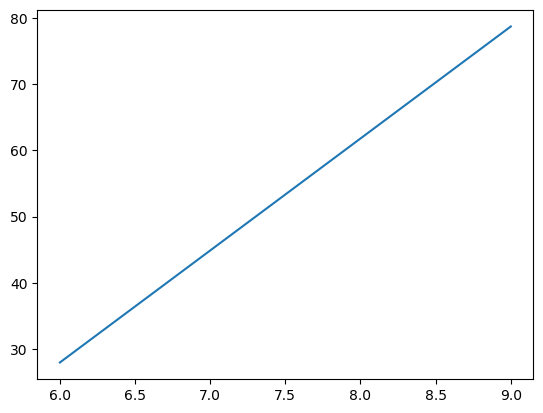

2-element Array{Float64,1}:
 27.941176470588236
 78.75

In [511]:
# 3秒差を検出するために必要なサンプルサイズを推定
exp_plot_minimum_sample_size_welch(100, 0.05, 0.8, 5, 3)

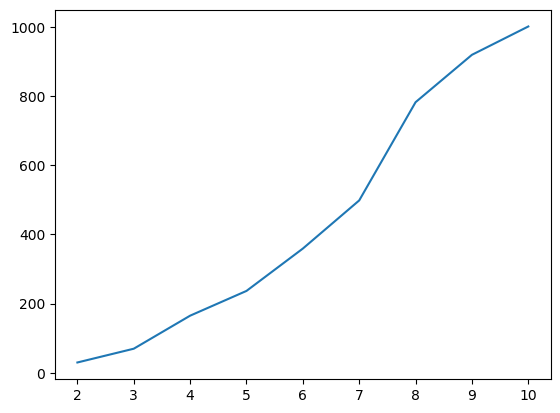

9-element Array{Float64,1}:
   29.565217391304348
   69.41176470588235
  165.0
  236.66666666666663
  359.23076923076917
  498.57142857142856
  782.8571428571429
  919.9999999999998
 1002.0

In [512]:
# 1秒差を検出するために必要なサンプルサイズを推定
exp_plot_minimum_sample_size_welch(100, 0.05, 0.8, 10, 1)

690.0
703.3333333333331
683.9999999999998
639.9999999999998
799.9999999999997
626.6666666666666
700.0
759.1666666666666
580.0
658.3333333333333
